In [2]:
import os
from glob import glob
import torch
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityRanged,
    CropForegroundd,
    Spacingd,
    ToTensord,
    Resized,
    Orientationd
)
from monai.data import Dataset, DataLoader
from monai.networks.nets import UNet 
from monai.networks.layers import Norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import nibabel as nib

c:\Users\skan2\OneDrive\Desktop\Epilepsy_well_structured\myenv\Lib\site-packages\monai\utils\module.py:340: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  pkg = __import__(module)  # top level module


In [3]:
from pathlib import Path
import nibabel as nib
import os

LABEL_DIR = Path(
    r"C:/Users/skan2/OneDrive/Desktop/Epilepsy_well_structured/prepared_ds/labelsTr"
)

removed_files = []

for file_path in LABEL_DIR.glob("*"):
    if not file_path.is_file():
        continue

    try:
        nib.load(str(file_path))
    except Exception as e:
        print(f"REMOVING BAD FILE: {file_path.name}")
        print(f"  Reason: {e}")
        os.remove(file_path)
        removed_files.append(file_path.name)

print("\nCleanup complete.")
print(f"Total files removed: {len(removed_files)}")

if removed_files:
    print("Removed files:")
    for f in removed_files:
        print(" -", f)



Cleanup complete.
Total files removed: 0


In [4]:
IMAGE_DIR = Path(
    r"C:/Users/skan2/OneDrive/Desktop/Epilepsy_well_structured/prepared_ds/imagesTr"
)

for file_path in IMAGE_DIR.glob("*"):
    try:
        nib.load(str(file_path))
    except Exception as e:
        print(f"REMOVING BAD IMAGE: {file_path.name}")
        os.remove(file_path)


In [5]:
dir = 'C:/Users/skan2/OneDrive/Desktop/Epilepsy_well_structured/prepared_ds'

train_image_set = len(os.listdir(os.path.join(dir, 'imagesTr')))*0.8
train_label_set = len(os.listdir(os.path.join(dir, 'labelsTr')))*0.8
val_image_set = len(os.listdir(os.path.join(dir, 'imagesTr')))*0.1
val_label_set = len(os.listdir(os.path.join(dir, 'labelsTr')))*0.1

images = sorted(glob(os.path.join(dir, 'imagesTr', '*.nii.gz')))
labels = sorted(glob(os.path.join(dir, 'labelsTr', '*.nii.gz')))

train_files = [{'image': img, 'label': lbl} for img, lbl in zip(images[:int(train_image_set)+1], labels[:int(train_label_set)+1])]
val_files = [{'image': img, 'label': lbl} for img, lbl in zip(images[:int(val_image_set)+1], labels[:int(val_label_set)+1])]


In [6]:
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),

    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest"),
        diagonal=True
    ),

    CropForegroundd(
        keys=["image", "label"],
        source_key="image"
    ),

    Resized(
        keys=["image", "label"],
        spatial_size=(128, 128, 64),
        mode=("trilinear", "nearest")
    ),

    ScaleIntensityRanged(
        keys=["image"],
        a_min=-200,
        a_max=200,
        b_min=0.0,
        b_max=1.0,
        clip=True
    ),

    ToTensord(keys=["image", "label"]),
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),

    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest"),
        diagonal=True
    ),

    CropForegroundd(
        keys=["image", "label"],
        source_key="image"
    ),

    Resized(
        keys=["image", "label"],
        spatial_size=(128, 128, 64),
        mode=("trilinear", "nearest")
    ),

    ScaleIntensityRanged(
        keys=["image"],
        a_min=-200,
        a_max=200,
        b_min=0.0,
        b_max=1.0,
        clip=True
    ),

    ToTensord(keys=["image", "label"]),
])


In [7]:
train_dataset = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataset = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [8]:
from utilities import train, show_patient

import torch
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,   
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH
).to(device)

data_in = (train_loader, val_loader)

loss_function = DiceLoss(
    sigmoid=True,     # REQUIRED for out_channels=1
    squared_pred=False
)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-5,
    weight_decay=1e-5
)
model_dir = r"C:/Users/skan2/OneDrive/Desktop/Epilepsy_well_structured/model_dir"


In [8]:
if __name__ == "__main__":
    train(model, data_in, loss_function, optimizer, 30, model_dir)

----------
epoch 1/30
1/347,Train_loss: 0.9914
Train_dice: 0.0133


c:\Users\skan2\OneDrive\Desktop\Epilepsy_well_structured\myenv\Lib\site-packages\monai\losses\dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


2/347,Train_loss: 0.9849
Train_dice: 0.0229
3/347,Train_loss: 0.9862
Train_dice: 0.0207
4/347,Train_loss: 0.9894
Train_dice: 0.0160
5/347,Train_loss: 0.9973
Train_dice: 0.0043
6/347,Train_loss: 0.9889
Train_dice: 0.0169
7/347,Train_loss: 0.9869
Train_dice: 0.0196
8/347,Train_loss: 0.9894
Train_dice: 0.0162
9/347,Train_loss: 0.9864
Train_dice: 0.0201
10/347,Train_loss: 0.9847
Train_dice: 0.0249
11/347,Train_loss: 0.9931
Train_dice: 0.0102
12/347,Train_loss: 0.9810
Train_dice: 0.0293
13/347,Train_loss: 0.9875
Train_dice: 0.0191
14/347,Train_loss: 0.9894
Train_dice: 0.0159
15/347,Train_loss: 0.9972
Train_dice: 0.0044
16/347,Train_loss: 0.9889
Train_dice: 0.0181
17/347,Train_loss: 0.9912
Train_dice: 0.0135
18/347,Train_loss: 0.9897
Train_dice: 0.0147
19/347,Train_loss: 0.9839
Train_dice: 0.0237
20/347,Train_loss: 0.9895
Train_dice: 0.0159
21/347,Train_loss: 0.9668
Train_dice: 0.0479
22/347,Train_loss: 0.9800
Train_dice: 0.0297
23/347,Train_loss: 0.9988
Train_dice: 0.0019
24/347,Train_loss:

c:\Users\skan2\OneDrive\Desktop\Epilepsy_well_structured\myenv\Lib\site-packages\monai\data\utils.py:766: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         212.92197719]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


253/347,Train_loss: 0.9829
Train_dice: 0.0178
254/347,Train_loss: 0.9939
Train_dice: 0.0093
255/347,Train_loss: 0.9814
Train_dice: 0.0193
256/347,Train_loss: 0.9999
Train_dice: 0.0001
257/347,Train_loss: 0.9831
Train_dice: 0.0179
258/347,Train_loss: 0.9817
Train_dice: 0.0191


c:\Users\skan2\OneDrive\Desktop\Epilepsy_well_structured\myenv\Lib\site-packages\monai\data\utils.py:766: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         219.85301476]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


259/347,Train_loss: 0.9825
Train_dice: 0.0225
260/347,Train_loss: 0.9774
Train_dice: 0.0236
261/347,Train_loss: 0.9994
Train_dice: 0.0010
262/347,Train_loss: 0.9744
Train_dice: 0.0280
263/347,Train_loss: 0.9806
Train_dice: 0.0204
264/347,Train_loss: 0.9849
Train_dice: 0.0241
265/347,Train_loss: 0.9758
Train_dice: 0.0260
266/347,Train_loss: 0.9846
Train_dice: 0.0165
267/347,Train_loss: 0.9811
Train_dice: 0.0199
268/347,Train_loss: 0.9779
Train_dice: 0.0240
269/347,Train_loss: 0.9749
Train_dice: 0.0266
270/347,Train_loss: 0.9794
Train_dice: 0.0213
271/347,Train_loss: 0.9811
Train_dice: 0.0193
272/347,Train_loss: 0.9958
Train_dice: 0.0043
273/347,Train_loss: 0.9934
Train_dice: 0.0094
274/347,Train_loss: 0.9829
Train_dice: 0.0203
275/347,Train_loss: 0.9812
Train_dice: 0.0207
276/347,Train_loss: 0.9900
Train_dice: 0.0177
277/347,Train_loss: 0.9867
Train_dice: 0.0138
278/347,Train_loss: 0.9871
Train_dice: 0.0216
279/347,Train_loss: 0.9903
Train_dice: 0.0099
280/347,Train_loss: 0.9984
Train_d

c:\Users\skan2\OneDrive\Desktop\Epilepsy_well_structured\myenv\Lib\site-packages\monai\data\utils.py:766: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.          1.          1.        215.0294823]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


304/347,Train_loss: 0.9742
Train_dice: 0.0301
305/347,Train_loss: 0.9768
Train_dice: 0.0256
306/347,Train_loss: 0.9848
Train_dice: 0.0233
307/347,Train_loss: 0.9768
Train_dice: 0.0243
308/347,Train_loss: 0.9798
Train_dice: 0.0205
309/347,Train_loss: 0.9937
Train_dice: 0.0065
310/347,Train_loss: 0.9818
Train_dice: 0.0188
311/347,Train_loss: 0.9795
Train_dice: 0.0228
312/347,Train_loss: 0.9771
Train_dice: 0.0324
313/347,Train_loss: 0.9996
Train_dice: 0.0006
314/347,Train_loss: 0.9680
Train_dice: 0.0355
315/347,Train_loss: 0.9850
Train_dice: 0.0154
316/347,Train_loss: 0.9991
Train_dice: 0.0011
317/347,Train_loss: 0.9894
Train_dice: 0.0173
318/347,Train_loss: 0.9852
Train_dice: 0.0158
319/347,Train_loss: 0.9750
Train_dice: 0.0256
320/347,Train_loss: 0.9778
Train_dice: 0.0238
321/347,Train_loss: 0.9931
Train_dice: 0.0101
322/347,Train_loss: 0.9731
Train_dice: 0.0290
323/347,Train_loss: 0.9854
Train_dice: 0.0149
324/347,Train_loss: 0.9937
Train_dice: 0.0108
325/347,Train_loss: 0.9750
Train_d

c:\Users\skan2\OneDrive\Desktop\Epilepsy_well_structured\myenv\Lib\site-packages\monai\data\utils.py:766: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         207.50782128]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


341/347,Train_loss: 0.9859
Train_dice: 0.0143
342/347,Train_loss: 0.9793
Train_dice: 0.0250
343/347,Train_loss: 0.9962
Train_dice: 0.0045
344/347,Train_loss: 0.9800
Train_dice: 0.0252
345/347,Train_loss: 0.9784
Train_dice: 0.0228
346/347,Train_loss: 0.9856
Train_dice: 0.0153
347/347,Train_loss: 0.9760
Train_dice: 0.0262
--------------------
Epoch_loss: 0.9854
Epoch_metric: 0.0184
test_loss_epoch: 0.9852
test_dice_epoch: 0.0187
current epoch: 1 current mean dice: 0.0287
best mean dice: 0.0187 at epoch: 1
----------
epoch 2/30
1/347,Train_loss: 0.9860
Train_dice: 0.0146
2/347,Train_loss: 0.9972
Train_dice: 0.0044
3/347,Train_loss: 0.9794
Train_dice: 0.0207
4/347,Train_loss: 0.9658
Train_dice: 0.0356
5/347,Train_loss: 0.9804
Train_dice: 0.0205
6/347,Train_loss: 0.9828
Train_dice: 0.0236
7/347,Train_loss: 0.9987
Train_dice: 0.0023
8/347,Train_loss: 0.9735
Train_dice: 0.0288
9/347,Train_loss: 0.9894
Train_dice: 0.0142
10/347,Train_loss: 0.9749
Train_dice: 0.0260
11/347,Train_loss: 0.9844
Tr

In [9]:
model.load_state_dict(
    torch.load(
        r"C:/Users/skan2/OneDrive/Desktop/Epilepsy_well_structured/model_dir/best_metric_model.pth",
        map_location=device
    )
)

model.eval()  # VERY IMPORTANT


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [10]:
from monai.utils import first

val_iter = iter(val_loader)


Dice Score: 0.6532


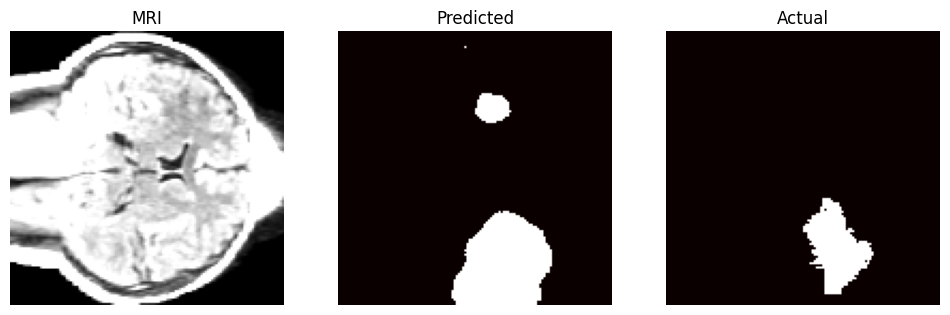

In [14]:
import matplotlib.pyplot as plt
from mri_models import dice_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample = next(val_iter)
image = sample["image"].to(device)
label = sample["label"].to(device)

with torch.no_grad():
    pred = model(image)
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    dice_score = dice_score(pred, label, 'UNet')
    print(f"Dice Score: {dice_score:.4f}")

img_np = image[0, 0].cpu().numpy()   # [H, W, D]
pred_np = pred[0, 0].cpu().numpy()   # [H, W, D]
gt = label[0, 0].cpu().numpy()

slice_idx = img_np.shape[2] // 2

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("MRI")
plt.imshow(img_np[:, :, slice_idx], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Predicted")
plt.imshow(pred_np[:, :, slice_idx], cmap="hot")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Actual")
plt.imshow(gt[:, :, slice_idx], cmap="hot")
plt.axis("off")

plt.show()


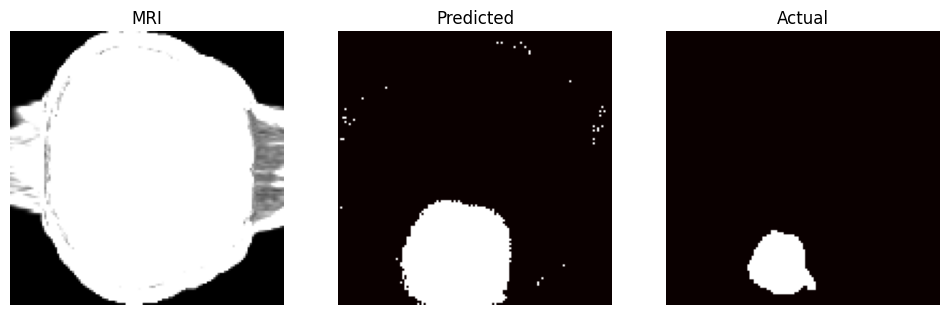

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("MRI")
plt.imshow(img_np[:, :, slice_idx], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Predicted")
plt.imshow(pred_np[:, :, slice_idx], cmap="hot")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Actual")
plt.imshow(gt[:, :, slice_idx], cmap="hot")
plt.axis("off")

plt.show()
